In [23]:
import numpy as np 
import pandas as pd 

In [24]:
df=pd.read_csv('redesign.csv')
df

,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0
...,...,...,...
40479,no,no,0
40480,yes,yes,0
40481,yes,yes,0
40482,no,no,0


In [25]:
df.columns

Index(['treatment', 'new_images', 'converted'], dtype='object')

#### Renaming the Treatment Column to LandingPage for Better Readability


In [26]:
df.rename(columns={'treatment':'landingPage'},inplace=True)

In [27]:
df

,landingPage,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0
...,...,...,...
40479,no,no,0
40480,yes,yes,0
40481,yes,yes,0
40482,no,no,0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   landingPage  40484 non-null  object
 1   new_images   40484 non-null  object
 2   converted    40484 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 949.0+ KB


#### Converting the Object Data Type to Category Data Type For Storage Optimization

In [29]:
df[['landingPage','new_images']] = df[['landingPage','new_images']].astype('category')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   landingPage  40484 non-null  category
 1   new_images   40484 non-null  category
 2   converted    40484 non-null  int64   
dtypes: category(2), int64(1)
memory usage: 395.7 KB


In [31]:
df.isna().sum()

landingPage    0
new_images     0
converted      0
dtype: int64

#### we are Going to Create 4 Groups

A:Control Group = > Old Image and Old Landing Page <br>
B:Treatment Group = > New Image and Old Landing Page <br>
C:Treatment Group = > Old Image and New Landing Page <br>
D:Treatment Group = > New Image and New Landing Page <br>

In [32]:
df['Groups'] = np.where((df['landingPage'] == 'no') & (df['new_images'] == 'no'), 'A',
                        np.where((df['landingPage'] == 'no') & (df['new_images'] == 'yes'), 'B',
                                 np.where((df['landingPage'] == 'yes') & (df['new_images'] == 'no'), 'C',
                                          np.where((df['landingPage'] == 'yes') & (df['new_images'] == 'yes'), 'D', ''))))

In [33]:
df

,landingPage,new_images,converted,Groups
0,yes,yes,0,D
1,yes,yes,0,D
2,yes,yes,0,D
3,yes,no,0,C
4,no,yes,0,B
...,...,...,...,...
40479,no,no,0,A
40480,yes,yes,0,D
40481,yes,yes,0,D
40482,no,no,0,A


### Conversion Rate Caln 

Each Group Converted Count 


In [34]:
convertedCount=df.groupby(by = 'Groups')['converted'].sum()
convertedCount

Groups
A    1084
B    1139
C    1215
D    1151
Name: converted, dtype: int64

Lets Find a Conversion Rate <br>
Conversion Rate = (Converted Count / Total Count )

In [35]:
totalCount= df.groupby(by='Groups')['converted'].count()

In [36]:
CountCalnDf=pd.DataFrame({'ConvertedCount':convertedCount,'TotalCount':totalCount})

In [37]:
CountCalnDf['ConversionRate']=CountCalnDf['ConvertedCount']/CountCalnDf['TotalCount']

In [38]:
CountCalnDf

,ConvertedCount,TotalCount,ConversionRate
Groups,,,
A,1084,10121,0.107104
B,1139,10121,0.112538
C,1215,10121,0.120047
D,1151,10121,0.113724


<AxesSubplot:xlabel='Groups'>

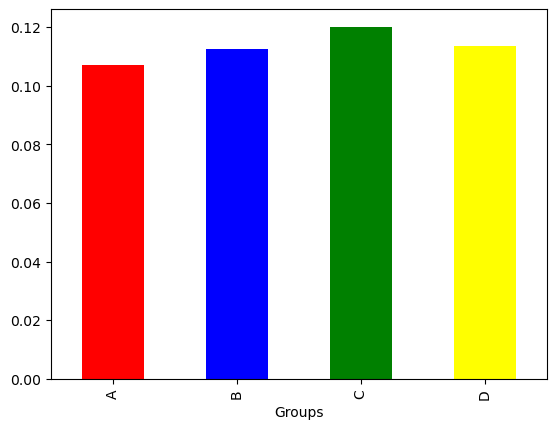

In [39]:
CountCalnDf.plot(kind='bar',y='ConversionRate',color=['red','blue','green','yellow'],legend=False)

#### Hypothesis Testing 

###### H0 : The Control and Treatment Group Have the same Impact <br>
###### H1: The Control and Treatment Group Does not have Same Impact 

I'm Taking Confidence Level as Standard 95%,Because there is No TradeOff Needed Here as its Not Involved Much Cost Because we already Took the Data .

#### As we are having 4 Groups of Conversion ,instead of Doing t-test or Z-test and Compare with Different Groups ,In one shot we can Chi Square Test of Independenc with Contingency Table and then if there is a Significant Difference between Population and Sample Proportion then  We will Go deep with Ztest between Different Groups will conclude which is Best .Or else We will Stop here Itsel if there is no significant Difference


In [54]:
from scipy.stats import chi2_contingency
convertedCount=CountCalnDf['ConvertedCount']
nonConvertedCount=CountCalnDf['TotalCount']-CountCalnDf['ConvertedCount']
conversion_data = np.column_stack((convertedCount, nonConvertedCount))
print(conversion_data)
chi2_stat, p_val, dof, expected = chi2_contingency(conversion_data)

print("Chi-Square Statistic:", chi2_stat)
print("P-Value:", p_val)


[[1084 9037]
 [1139 8982]
 [1215 8906]
 [1151 8970]]
Chi-Square Statistic: 8.526056765102425
P-Value: 0.03630328708083606


From the P value Its clearly visible that We have Enough evidence to reject the Null Hypothesis ,That is there is a Significant difference between Different Groups and Conversion Rate 

Our Next step is to find out which Group is the best Design by using Proportion Z test by comparing a Control Group with Every Treatment group

In [58]:
def test_pvalue(p):
    if p < 0.01:
        s = 'Very strong evidence against Null Hypothesis'
    elif p < 0.05:
        s = 'Strong evidence against Null Hypothesis'
    elif p < 0.1:
        s = 'Very weak evidence against Null Hypothesis'
    else:
        s = 'Small to no evidence against Null Hypothesis'
    return s

In [64]:
from scipy import stats 
from statsmodels.stats.proportion import  proportion_confint,proportions_ztest
def CheckHypothesis():
    for i in ['B','C','D']:
        ControlSuccess=CountCalnDf['ConvertedCount']['A']
        nObs=CountCalnDf['TotalCount']['A']
        treatmentSucessB = CountCalnDf['ConvertedCount'][i]
        success=[ControlSuccess,treatmentSucessB]
        zCal,pVal=proportions_ztest(success,nObs)
        print(zCal,pVal)
        print (test_pvalue(pVal))

CheckHypothesis()
    

    

-1.2363867031898539 0.2163148562938333
Small to no evidence against Null Hypothesis
-2.9018903061123846 0.0037091839675173722
Very strong evidence against Null Hypothesis
-1.5025954414248646 0.13294339963478088
Small to no evidence against Null Hypothesis


#  So For Group A and Group C is Having significant Difference From this we are concluding that Old Landing Page is the Problem If we change the Old Landing and Old Image with new Landing and Old Image Means Our Conversion rate is High.
A:Control Group = > Old Image and Old Landing Page
C:Treatment Group = > Old Image and New Landing Page